Coupling map:


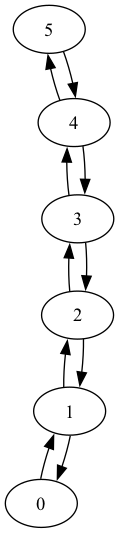

In [1]:
from gymnasium.wrappers.vector import ClipAction

from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "ry", "rx", "ry", "rx", "ry"]
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

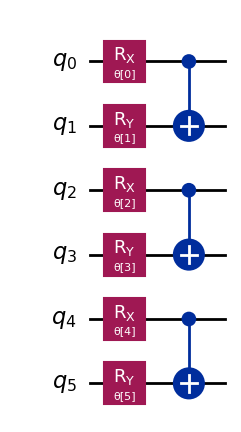

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {ParameterVectorElement(θ[0]): 2.353304971691044, ParameterVectorElement(θ[1]): 5.9735141613602165, ParameterVectorElement(θ[2]): 4.599253580133889, ParameterVectorElement(θ[3]): 3.761482191925223, ParameterVectorElement(θ[4]): 0.980294029274052, ParameterVectorElement(θ[5]): 0.9801424781769557}


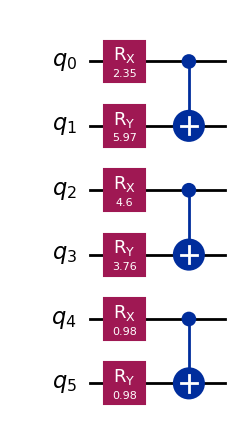

In [3]:
seed = 42
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

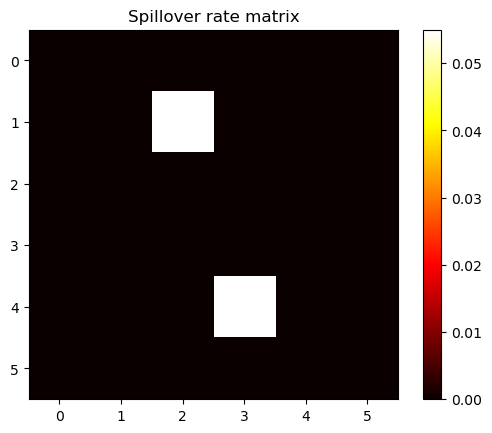

In [4]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.00  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.055  # γ_1->2
gamma_matrix[2, 3] = 0.0  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.055  # γ_4->3
gamma_matrix[5, 4] = 0.00  # γ_5->4

# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")
plt.show()

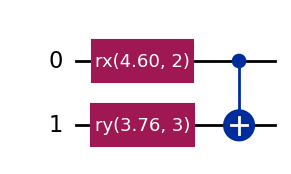

In [5]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [6]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [7]:
print("Rotation angles:", rotation_angles)

Rotation angles: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248]


In [8]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '20d6ca1314eb4ad3981b9e4cf4a3c727',
   'operations': ['rx(4.60, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[ 0.98653773+0.j, -0.16353382+0.j],
              [ 0.16353382+0.j,  0.98653773+0.j]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]},
  {'type': 'qerror',
   'id': '139343f866d54f7b836c549c8e351c42',
   'operations': ['ry(3.76, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99963665+0.j        , 0.        -0.02695482j],
              [0.        -0.02695482j, 0.99963665+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [9]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[ 0.20313331+0.j        ,  0.        +0.22752042j,
            0.63426316+0.j        ,  0.        +0.71040943j],
          [ 0.        -0.71040943j, -0.63426316+0.j        ,
            0.        +0.22752042j,  0.20313331+0.j        ],
          [-0.63426316+0.j        ,  0.        -0.71040943j,
            0.20313331+0.j        ,  0.        +0.22752042j],
          [ 0.        +0.22752042j,  0.20313331+0.j        ,
            0.        +0.71040943j,  0.63426316+0.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))


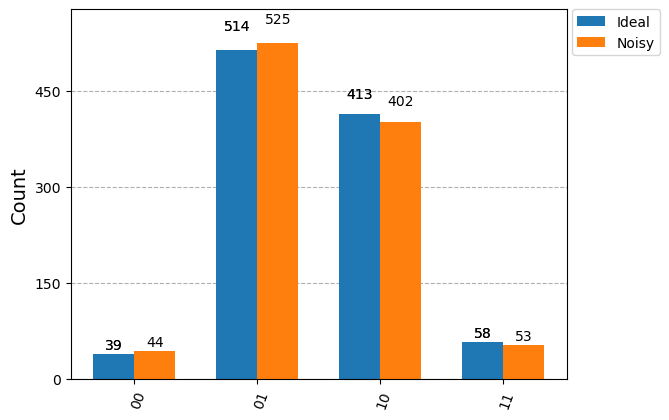

In [10]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [11]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [12]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9780396466270596

In [13]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )

    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [14]:
# Define the environment
from gymnasium.spaces import Box
from gymnasium.wrappers import ClipAction, RescaleAction
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    QiskitConfig,
)

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-0.2, high=0.2, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=64,
        n_reps=4,
        n_shots=1000,
        sampling_paulis=500,
    ),
    reward_config="channel",
)
q_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=qc_noisy,  # Pass the circuit already transpiled through custom pass
)
rescaled_env = RescaleAction(q_env, -1, 1)

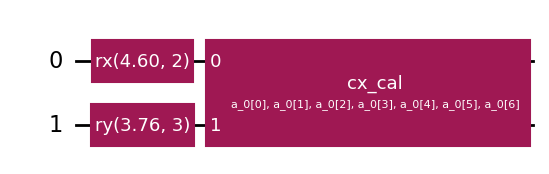

In [15]:
q_env.circuits[0].draw(output="mpl")

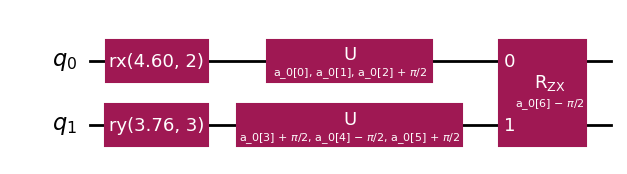

In [16]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [17]:
q_env.simulate_circuit(q_env.circuits[0], np.zeros((1, 7)), False)

[0.9780396466270596]

In [18]:
from rl_qoc.helpers import load_from_yaml_file

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = file_name

agent_config = load_from_yaml_file(file_location)

In [19]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env, save_data=True)
total_updates = 500
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=True,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: arthurostrauss (quantumcontrolwithrl). Use `wandb login --relogin` to force relogin


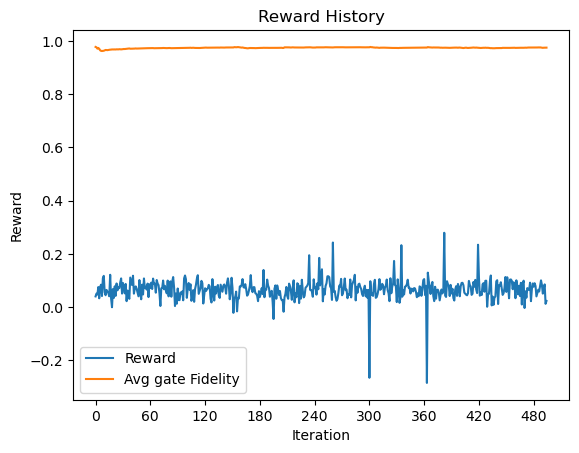

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.97500402491312
Sending Estimator job...
Time for running 0.34396886825561523
Finished Estimator job
Reward (avg): 0.06124303499713263 Std: 0.0015639452676794966
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9750203373966972
Sending Estimator job...
Time for running 0.33768796920776367
Finished Estimator job
Reward (avg): 0.08541429566462037 Std: 0.001306565318806203
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9752714380689825
Sending Estimator job...
Time for running 0.3325986862182617
Finished Estimator job
Reward (avg): 0.06459139888263535 Std: 0.001329539373185064
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9749705806339307
Sending Estimator job...
Time for running 0.3225080966949463
Finished Estimator job
Reward (avg): 0.09578090530027684 Std: 0.0013865071577867977


avg_reward,▆▅▆▃▇▅▆▁▂▄▃▇▄█▄▃▃▇█▂▆▃▇▆▇▆▅▃▃▅▄▆▂▃▄▆▇▇▅▅
fidelity_history,▁▂▂▅▄▅▆▆▇▇▇▇▆▇▇██▇██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▇
total_shots,▆▆█▆▄▄▆▄▅▅▂▆▆▇▄▄▅▅▅▄▅▄▄▄▃▄▄▅▂▄▄▆▆▄▃█▁▃▅▆
total_updates,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇███
env_ident_str,gate_calibration_cx-...
hardware_runtime,nan
n_reps,4
reward_method,channel
total_shots,38527232
total_updates,499
training_constraint,TotalUpdates


{'avg_reward': [0.03998569730798571,
  0.05052500873798815,
  0.046913645893457326,
  0.07515532503192177,
  0.032899577160154105,
  0.07556213550373247,
  0.08405964363567861,
  0.04135339320921545,
  0.10842919109638588,
  0.11723262638450885,
  0.05578347487471769,
  0.04436825448274852,
  0.06440786251544794,
  0.058748782851126266,
  0.052641648915937346,
  0.040521563981165035,
  0.12123111235873688,
  0.03268791789829814,
  -0.0006459358516807684,
  0.06743347809588537,
  0.03432805454407853,
  0.07780630243601187,
  0.0419997641068945,
  0.08854102030823754,
  0.06281672857972312,
  0.073633025608797,
  0.07108820339895365,
  0.09207644209119384,
  0.10755031609995121,
  0.0506377304426045,
  0.09034109070322963,
  0.07290107815704333,
  0.05157364347570621,
  0.08684322905258351,
  0.0221601194422541,
  0.0619395925238131,
  0.04075601348294193,
  0.03079699355727408,
  0.1107803971443008,
  0.09600040085172268,
  0.08272550586325747,
  0.11764716248493925,
  0.050423567630575

<Figure size 640x480 with 0 Axes>

In [20]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

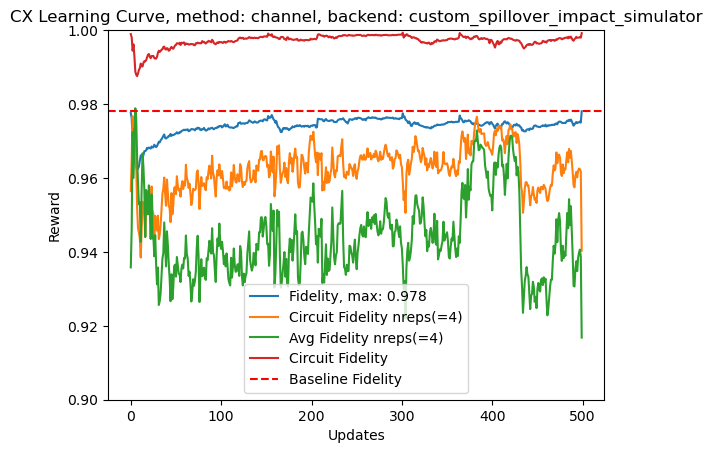

In [22]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(
    q_env.circuit_fidelity_history_nreps,
    label=f"Circuit Fidelity nreps(={q_env.n_reps})",
)
plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    q_env.simulate_circuit(q_env.circuits[0], np.zeros((1, 7))),
    label="Baseline Fidelity",
    color="red",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.ylim(0.9, 1.0)
plt.legend()
plt.show()

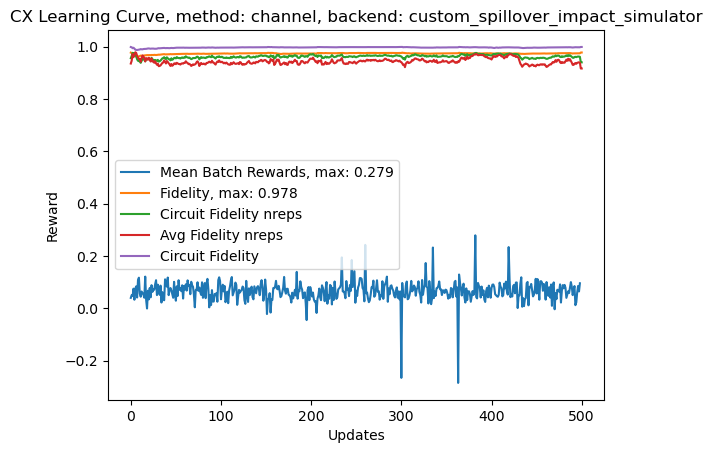

In [23]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [24]:
q_env.optimal_action

array([ 0.03540956, -0.04816176, -0.05046359, -0.07157736,  0.04494574,
       -0.0487302 , -0.05401159], dtype=float32)

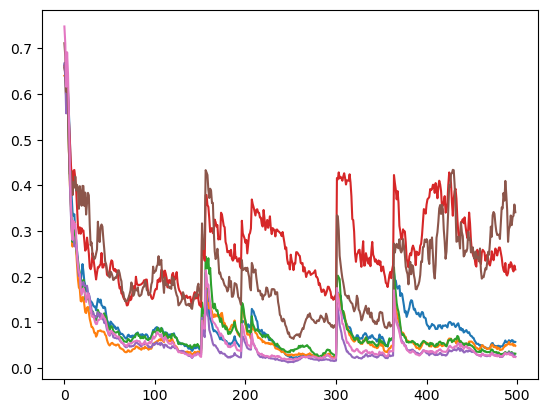

In [26]:
plt.plot(ppo_agent.training_results["std_action"])

In [28]:
q_env.total_shots

38527232

In [30]:
%wandb